# MIKH Model: Small Amplitude Oscillatory Shear (SAOS)

## Learning Objectives

1. Generate **synthetic SAOS data** from calibrated MIKH parameters
2. Understand the **linear viscoelastic moduli** $G'(\omega)$ and $G''(\omega)$
3. Extract moduli from the MIKH Maxwell backbone
4. Fit and validate the model on oscillatory data
5. Compare with analytical Maxwell predictions

## Prerequisites

- NB01: MIKH Flow Curve (provides calibrated parameters)

## Runtime

- Fast demo: ~3-4 minutes
- Full run: ~10-12 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.ikh import MIKH

# Add examples/utils to path for tutorial utilities
sys.path.insert(0, os.path.join("..", "utils"))
from ikh_tutorial_utils import (
    load_ikh_parameters,
    set_model_parameters,
    generate_synthetic_saos,
    save_ikh_results,
    print_convergence_summary,
    print_parameter_comparison,
    compute_fit_quality,
    get_mikh_param_names,
)

# Shared plotting utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    plot_nlsq_fit,
    display_arviz_diagnostics,
    plot_posterior_predictive,
)

jax, jnp = safe_import_jax()
verify_float64()

# Suppress equinox DeprecationWarnings for jax.core.mapped_aval/unmapped_aval
# (third-party equinox internals, cannot fix at source — harmless with JAX 0.8.x)
warnings.filterwarnings(
    "ignore",
    message=r"jax\.core\.(mapped|unmapped)_aval",
    category=DeprecationWarning,
    module=r"equinox\..*",
)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
# Startup cleanup: force garbage collection to reclaim memory from previous notebooks
import gc
gc.collect()


JAX version: 0.8.3
Devices: [CpuDevice(id=0)]


81

## 2. Theory: SAOS in MIKH

Small Amplitude Oscillatory Shear (SAOS) probes the **linear viscoelastic** response of materials.

### Applied Deformation

$$
\gamma(t) = \gamma_0 \sin(\omega t)
$$

where $\gamma_0 \ll 1$ (typically 0.001-0.01) ensures linear response.

### Stress Response

$$
\sigma(t) = \gamma_0 [G'(\omega) \sin(\omega t) + G''(\omega) \cos(\omega t)]
$$

### Maxwell Model Moduli

For a simple Maxwell element:
$$
G'(\omega) = G \frac{(\omega\tau)^2}{1 + (\omega\tau)^2}
$$
$$
G''(\omega) = G \frac{\omega\tau}{1 + (\omega\tau)^2}
$$

where $\tau = \eta/G$ is the Maxwell relaxation time.

### MIKH Modification

In the MIKH model, the linear viscoelastic response is dominated by the Maxwell backbone, but thixotropy can modify the effective modulus if the structure is not at equilibrium.

## 3. Load Calibrated Parameters

In [3]:
# Load calibrated parameters from NB01
try:
    calibrated_params = load_ikh_parameters("mikh", "flow_curve")
    print("Loaded calibrated parameters from NB01:")
    for name, val in calibrated_params.items():
        print(f"  {name:15s} = {val:.4g}")
except FileNotFoundError:
    # Provide sensible fallback parameters for SAOS
    print("NB01 results not found. Using fallback parameters suitable for SAOS.")
    calibrated_params = {
        "G": 100.0,           # Shear modulus [Pa]
        "eta": 1e4,           # Viscosity [Pa s] -> tau_M ~ 100 s
        "C": 50.0,            # Kinematic hardening [Pa]
        "gamma_dyn": 1.0,     # Dynamic recovery
        "m": 1.0,             # AF exponent
        "sigma_y0": 5.0,      # Base yield stress [Pa]
        "delta_sigma_y": 20.0,# Structural yield stress [Pa]
        "tau_thix": 10.0,     # Restructuring time [s]
    }

Loaded calibrated parameters from NB01:
  G               = 6.406e+08
  eta             = 5.157e+11
  C               = 5.673e+08
  gamma_dyn       = 805.8
  m               = 0.6097
  sigma_y0        = 1.441
  delta_sigma_y   = 6.586e+08
  tau_thix        = 9.577e+11
  Gamma           = 1776
  eta_inf         = 0.5078
  mu_p            = 637.2


In [4]:
# Create model and set parameters
model = MIKH()
param_names = get_mikh_param_names()

# Always set parameters (from NB01 or fallback)
set_model_parameters(model, calibrated_params)

# Get Maxwell parameters
G = model.parameters.get_value("G")
eta = model.parameters.get_value("eta")
tau_M = eta / G

print(f"\nMaxwell parameters:")
print(f"  G = {G:.4g} Pa")
print(f"  eta = {eta:.4g} Pa.s")
print(f"  tau_M = {tau_M:.4g} s")
print(f"  omega_crossover = 1/tau_M = {1/tau_M:.4g} rad/s")


Maxwell parameters:
  G = 6.406e+08 Pa
  eta = 5.157e+11 Pa.s
  tau_M = 804.9 s
  omega_crossover = 1/tau_M = 0.001242 rad/s


## 4. Generate Synthetic Data

In [5]:
# Generate synthetic SAOS data
omega_range = (0.01, 100.0)
n_points = 30
noise_level = 0.02  # 2% noise

omega, G_prime, G_double_prime = generate_synthetic_saos(
    model,
    omega_range=omega_range,
    n_points=n_points,
    noise_level=noise_level,
    seed=42,
)

print(f"Generated synthetic SAOS data:")
print(f"  Frequency range: [{omega.min():.3f}, {omega.max():.1f}] rad/s")
print(f"  G' range: [{G_prime.min():.2f}, {G_prime.max():.2f}] Pa")
print(f"  G'' range: [{G_double_prime.min():.2f}, {G_double_prime.max():.2f}] Pa")

Generated synthetic SAOS data:
  Frequency range: [0.010, 100.0] rad/s
  G' range: [615645962.97, 656308640.92] Pa
  G'' range: [0.00, 50.89] Pa


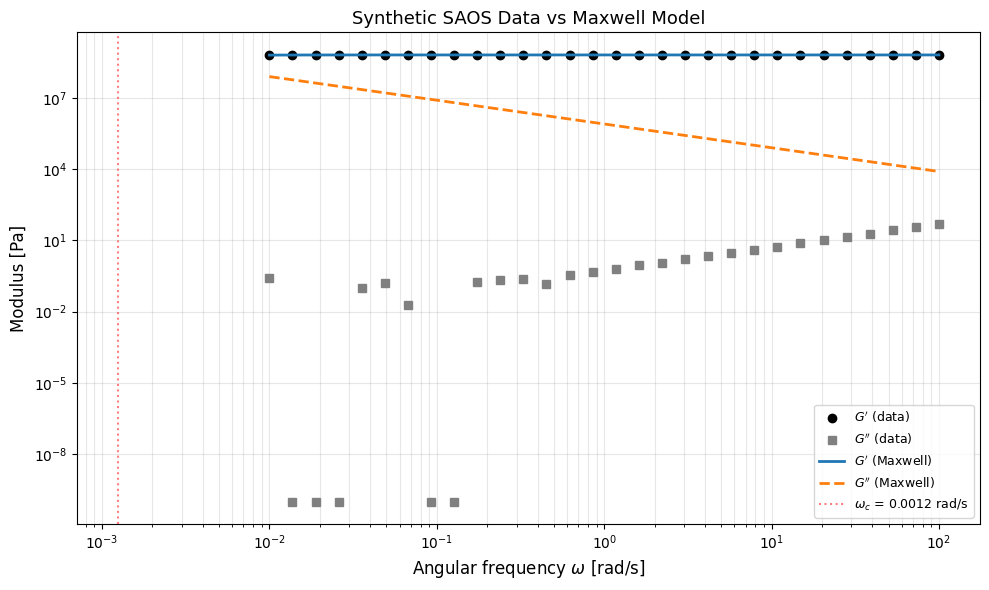

In [6]:
# Plot synthetic data with Maxwell reference
omega_fine = np.logspace(np.log10(omega_range[0]), np.log10(omega_range[1]), 100)
wt = omega_fine * tau_M
G_prime_maxwell = G * wt**2 / (1 + wt**2)
G_double_prime_maxwell = G * wt / (1 + wt**2)

fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(omega, G_prime, "ko", markersize=6, label="$G'$ (data)")
ax.loglog(omega, G_double_prime, "s", color="gray", markersize=6, label="$G''$ (data)")
ax.loglog(omega_fine, G_prime_maxwell, "-", lw=2, color="C0", label="$G'$ (Maxwell)")
ax.loglog(omega_fine, G_double_prime_maxwell, "--", lw=2, color="C1", label="$G''$ (Maxwell)")

# Mark crossover
ax.axvline(1/tau_M, color="red", linestyle=":", alpha=0.5, label=f"$\\omega_c$ = {1/tau_M:.2g} rad/s")

ax.set_xlabel("Angular frequency $\\omega$ [rad/s]", fontsize=12)
ax.set_ylabel("Modulus [Pa]", fontsize=12)
ax.set_title("Synthetic SAOS Data vs Maxwell Model", fontsize=13)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 5. NLSQ Fitting

We fit the MIKH model to the SAOS data to recover the Maxwell parameters.

In [7]:
# Prepare complex modulus data (G* = G' + iG'')
G_star = G_prime + 1j * G_double_prime

# Create fresh model for fitting
model_fit = MIKH()

# Fit to oscillation data
# Note: MIKH oscillation fitting uses return mapping with sinusoidal strain
t0 = time.time()
model_fit.fit(omega, np.abs(G_star), test_mode="oscillation", method='scipy')
t_nlsq = time.time() - t0

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
for name in ["G", "eta"]:
    val = model_fit.parameters.get_value(name)
    print(f"  {name:15s} = {val:.4g}")

G_fit = model_fit.parameters.get_value("G")
eta_fit = model_fit.parameters.get_value("eta")
tau_fit = eta_fit / G_fit
print(f"\nFitted Maxwell time: tau_M = {tau_fit:.4g} s")
print(f"True Maxwell time:   tau_M = {tau_M:.4g} s")

ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 713, in predict
    result = self._predict(X, **kwargs)
  File "/Users/b80985/Projects/rheojax/rheojax/models/ikh/mikh.py", line 460, in _predict
    times, strains = self._extract_time_strain(X, **kwargs)
                     ~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/rheojax/models/ikh/_base.py", line 61, in _extract_time_strain
    raise ValueError(
    ...<3 lines>...
    )
ValueError: IKH models require both time and strain history. Pass RheoData, or X of shape (2, N), or X=time with strain=gamma kwarg, or gamma_dot for startup, or gamma_0+omega for LAOS.


NLSQ fit time: 0.17 s

Fitted parameters:
  G               = 6.41e+08
  eta             = 8.401e+11

Fitted Maxwell time: tau_M = 1311 s
True Maxwell time:   tau_M = 804.9 s


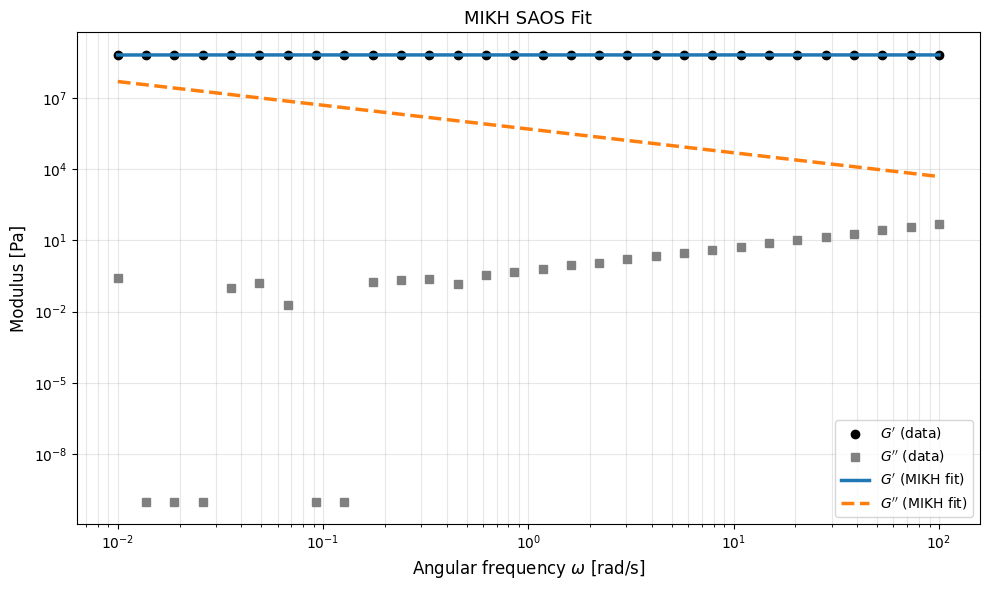

In [8]:
# Plot fitted moduli
wt_fit = omega_fine * tau_fit
G_prime_fit = G_fit * wt_fit**2 / (1 + wt_fit**2)
G_double_prime_fit = G_fit * wt_fit / (1 + wt_fit**2)

fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(omega, G_prime, "ko", markersize=6, label="$G'$ (data)")
ax.loglog(omega, G_double_prime, "s", color="gray", markersize=6, label="$G''$ (data)")
ax.loglog(omega_fine, G_prime_fit, "-", lw=2.5, color="C0", label="$G'$ (MIKH fit)")
ax.loglog(omega_fine, G_double_prime_fit, "--", lw=2.5, color="C1", label="$G''$ (MIKH fit)")

ax.set_xlabel("Angular frequency $\\omega$ [rad/s]", fontsize=12)
ax.set_ylabel("Modulus [Pa]", fontsize=12)
ax.set_title("MIKH SAOS Fit", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 6. Cole-Cole Analysis

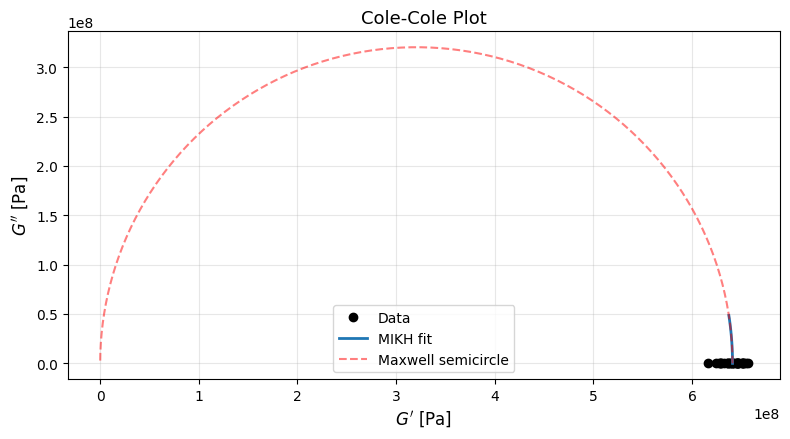

In [9]:
# Cole-Cole plot (G'' vs G')
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(G_prime, G_double_prime, "ko", markersize=6, label="Data")
ax.plot(G_prime_fit, G_double_prime_fit, "-", lw=2, color="C0", label="MIKH fit")

# Maxwell semicircle
theta = np.linspace(0, np.pi, 100)
ax.plot(G_fit/2 * (1 + np.cos(theta)), G_fit/2 * np.sin(theta), "--", 
        color="red", alpha=0.5, label="Maxwell semicircle")

ax.set_xlabel("$G'$ [Pa]", fontsize=12)
ax.set_ylabel("$G''$ [Pa]", fontsize=12)
ax.set_title("Cole-Cole Plot", fontsize=13)
ax.set_aspect("equal")
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

## 7. Bayesian Inference

In [10]:
# Bayesian inference for Maxwell parameters
initial_values = {name: model_fit.parameters.get_value(name) for name in param_names}

# FAST_MODE: reduced samples for CI; set FAST_MODE=0 for production
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

if FAST_MODE:
    NUM_WARMUP = 50
    NUM_SAMPLES = 100
    NUM_CHAINS = 1
else:
    NUM_WARMUP = 200
    NUM_SAMPLES = 500
    NUM_CHAINS = 1

print(f"Running NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
t0 = time.time()
result = model_fit.fit_bayesian(
    omega,
    np.abs(G_star),
    test_mode="oscillation",
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Running NUTS: 50 warmup + 100 samples x 1 chain(s)


  0%|          | 0/150 [00:00<?, ?it/s]

warmup:   1%|          | 1/150 [00:00<02:15,  1.10it/s, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:  29%|██▊       | 43/150 [00:01<00:01, 57.87it/s, 255 steps of size 1.35e-02. acc. prob=0.84]

sample:  94%|█████████▍| 141/150 [00:01<00:00, 207.25it/s, 31 steps of size 5.01e-02. acc. prob=0.99]

sample: 100%|██████████| 150/150 [00:01<00:00, 133.58it/s, 79 steps of size 5.01e-02. acc. prob=0.99]


Bayesian inference time: 3.3 s


In [11]:
# Convergence diagnostics (focus on Maxwell params)
print_convergence_summary(result, ["G", "eta"])

Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
              G    1.0051        64     CHECK
            eta    1.0871        33     CHECK

Divergences: 0

CHECK REQUIRED: Increase num_warmup/num_samples or check warm-start


False

/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/plots/backends/matplotlib/pairplot.py:223: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


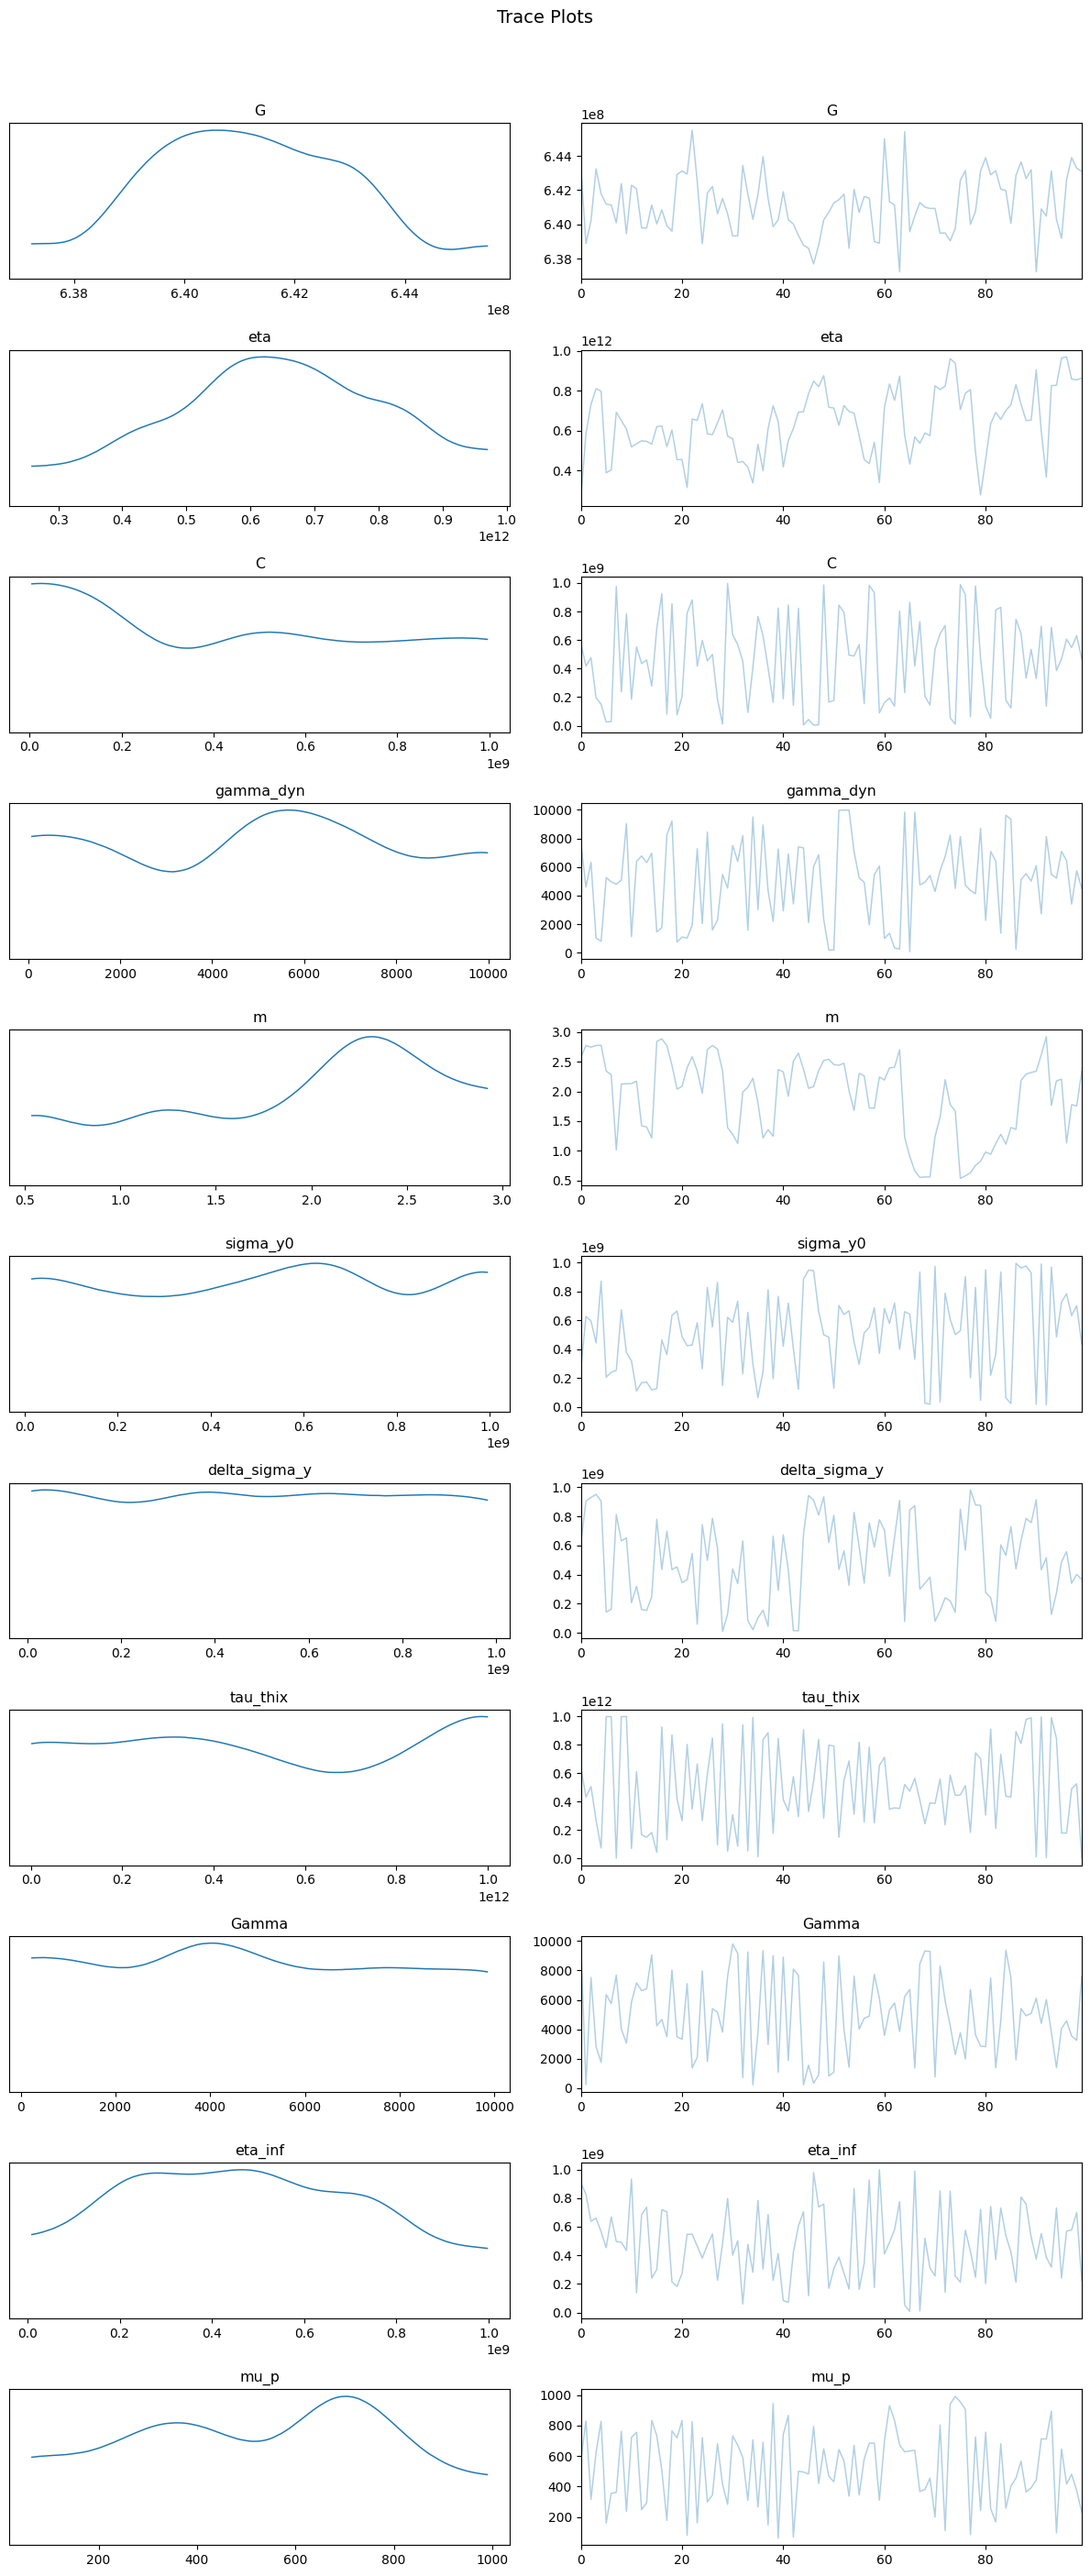

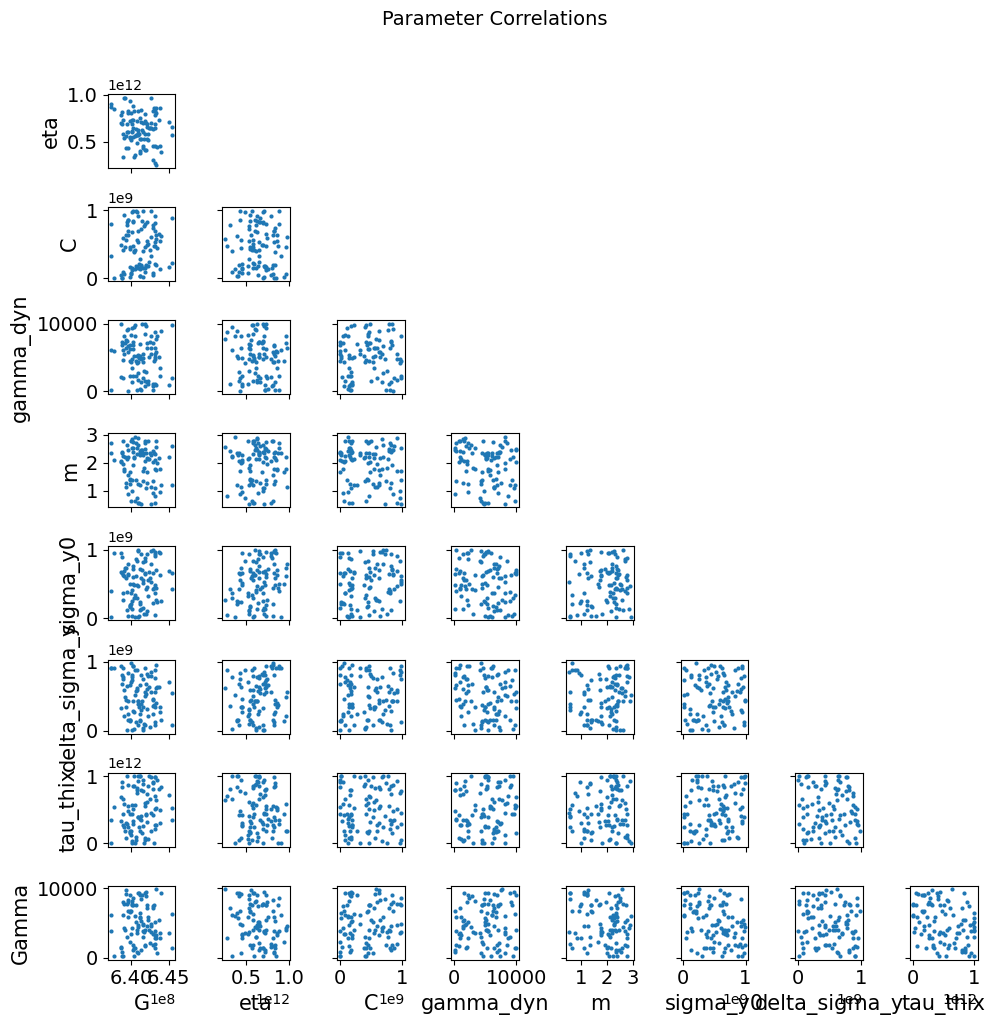

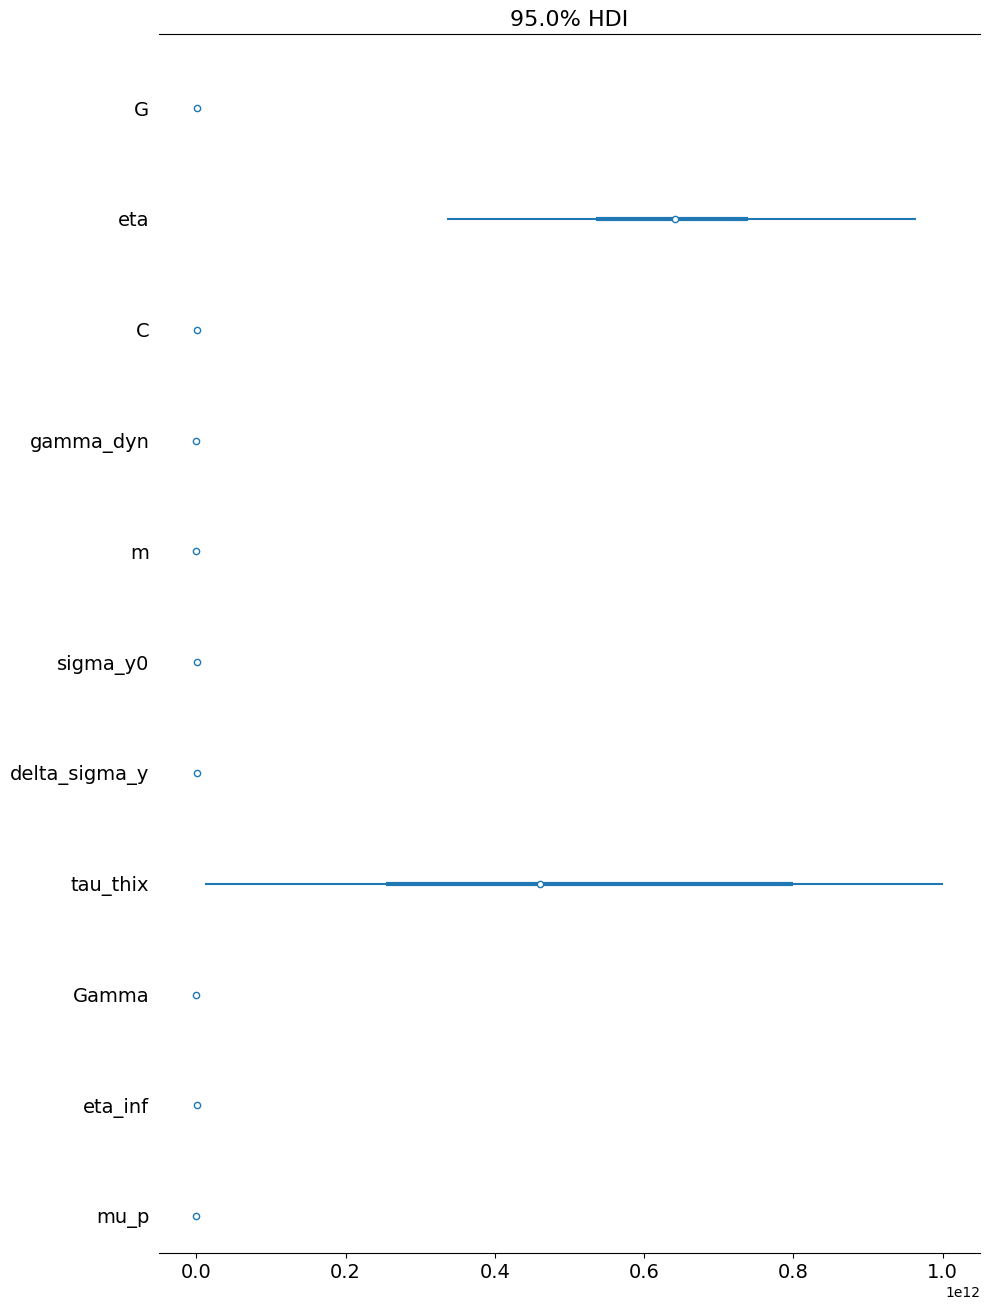

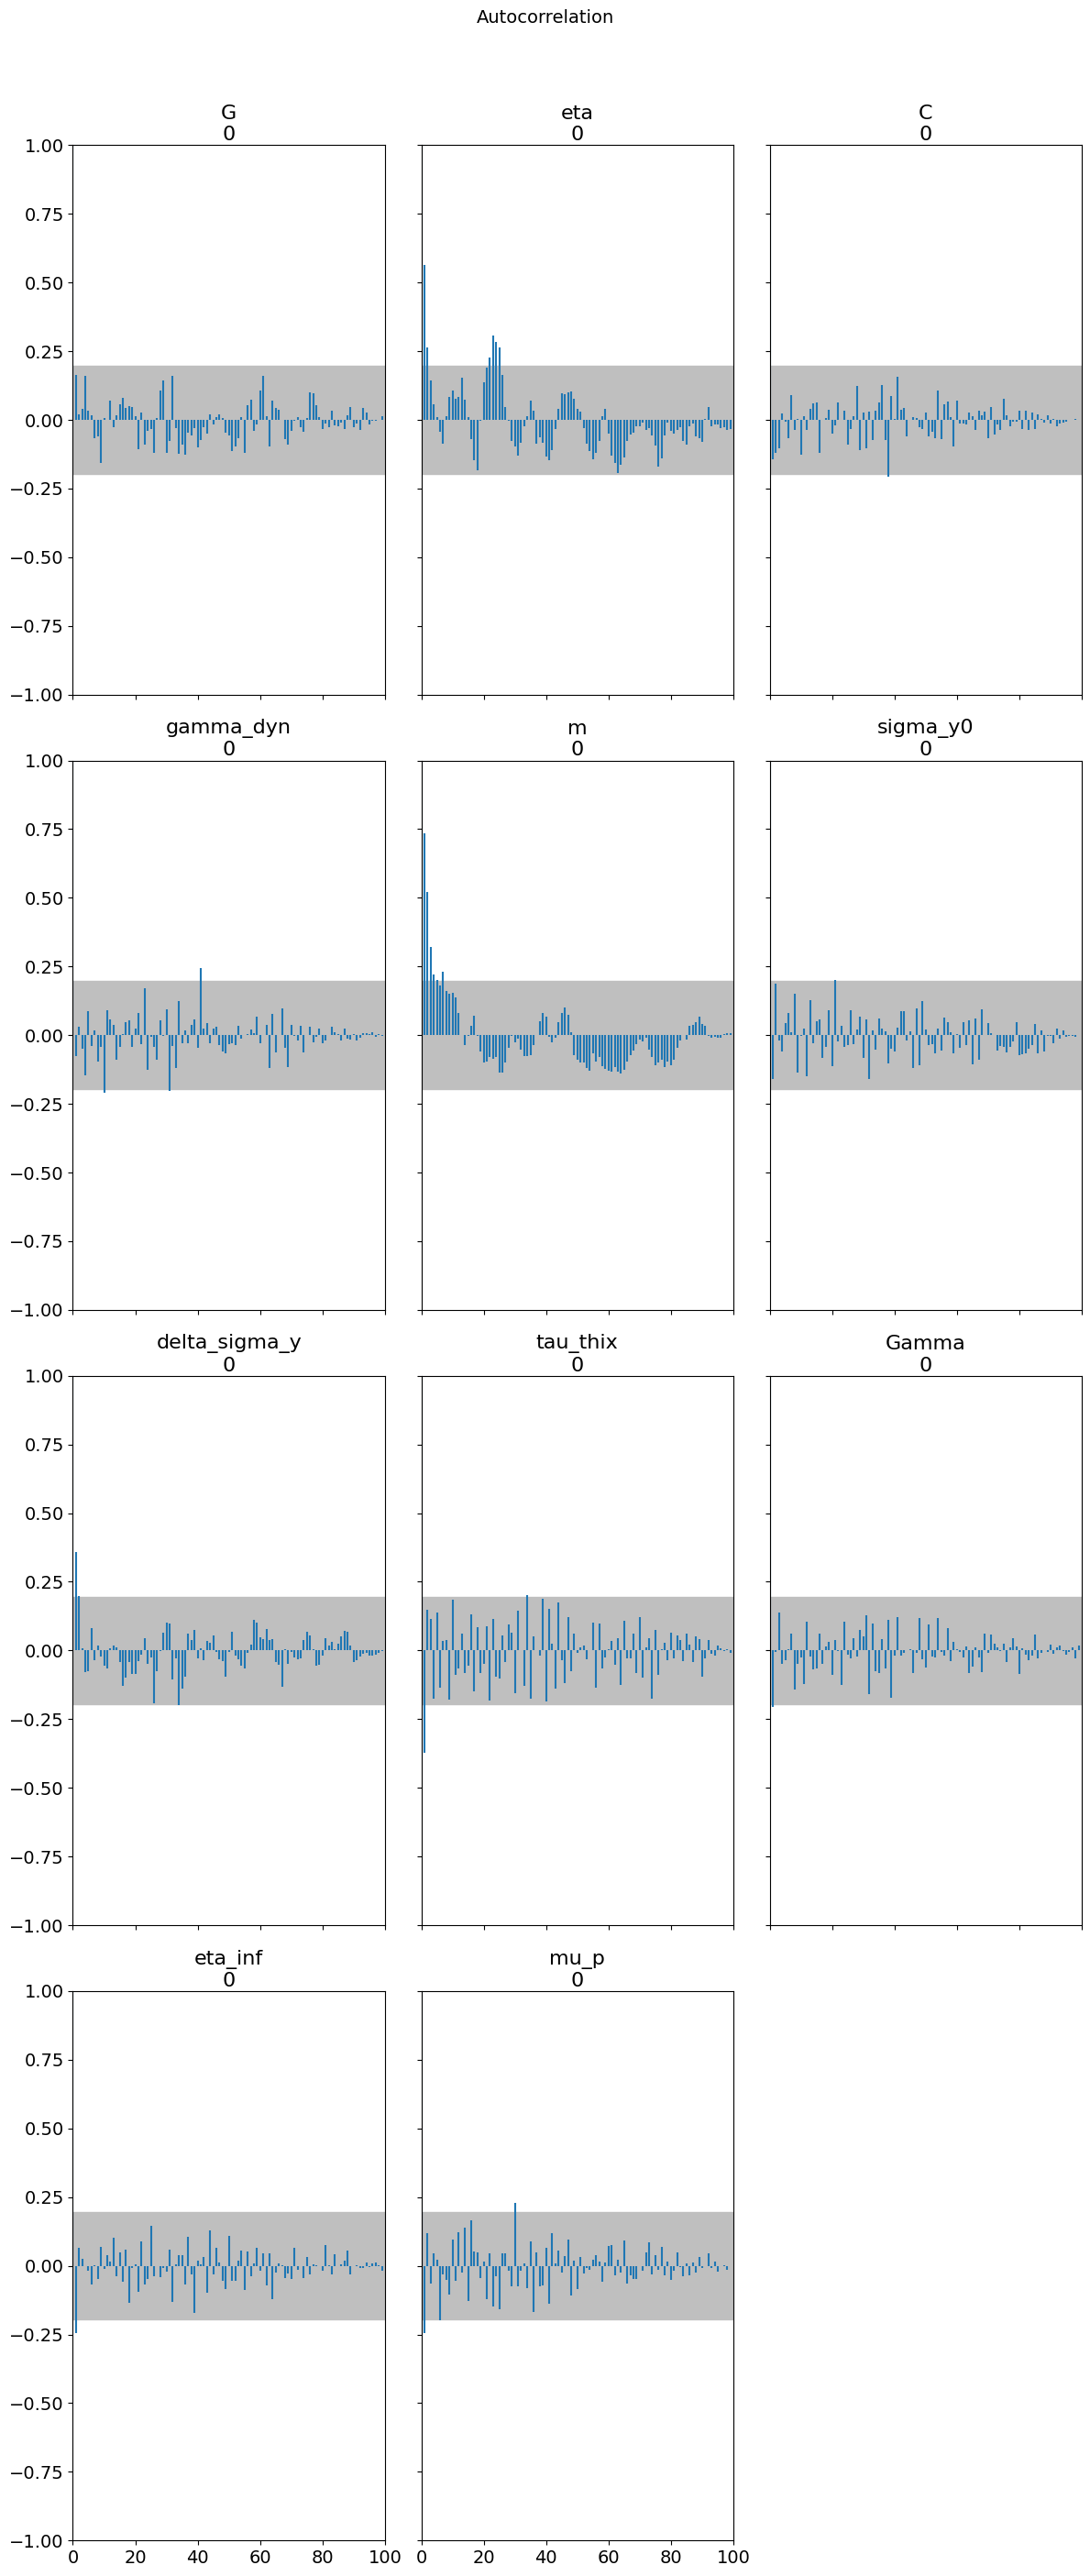

In [12]:
# ArviZ diagnostic plots (trace, pair, forest, energy, autocorrelation, rank)
display_arviz_diagnostics(result, param_names, fast_mode=FAST_MODE)

In [13]:
# Parameter comparison
posterior = result.posterior_samples
print_parameter_comparison(model_fit, posterior, ["G", "eta"])


Parameter Comparison: NLSQ vs Bayesian
      Parameter          NLSQ        Median                          95% CI
---------------------------------------------------------------------------
              G      6.41e+08     6.411e+08  [6.381e+08, 6.445e+08]
            eta     8.401e+11     6.415e+11  [3.242e+11, 9.501e+11]


## 8. Physical Interpretation

### Linear Viscoelastic Regime

SAOS probes the **linear viscoelastic** (LVE) properties of the material:
- At small amplitudes, the MIKH model behaves like a Maxwell element
- Yield stress and plasticity don't contribute (below yield)
- Pure elastic ($G'$) and viscous ($G''$) contributions separated

### Crossover Frequency

The crossover frequency $\omega_c = 1/\tau_M = G/\eta$ marks:
- $\omega < \omega_c$: Viscous-dominated ($G'' > G'$)
- $\omega > \omega_c$: Elastic-dominated ($G' > G''$)

### Thixotropy Effects

At low frequencies, thixotropic restructuring during the oscillation cycle can modify the apparent moduli if the oscillation period is comparable to $\tau_{thix}$.

## 9. Save Results

In [14]:
# Save results
save_ikh_results(model_fit, result, "mikh", "saos", param_names)

Results saved to /Users/b80985/Projects/rheojax/examples/ikh/../utils/../outputs/ikh/mikh/saos/
  nlsq_params_saos.json: 11 parameters
  posterior_saos.json: 100 draws


## Key Takeaways

1. **SAOS** probes the linear viscoelastic response of MIKH materials

2. The **Maxwell backbone** ($G$, $\eta$) determines the frequency-dependent moduli:
   - $G'(\omega) = G(\omega\tau)^2/(1 + (\omega\tau)^2)$
   - $G''(\omega) = G\omega\tau/(1 + (\omega\tau)^2)$

3. The **crossover frequency** $\omega_c = G/\eta$ separates viscous and elastic regimes

4. **Cole-Cole plots** reveal the Maxwell semicircle for single-mode relaxation

5. SAOS provides clean characterization of $G$ and $\eta$ without yield/plasticity complications

### Next Steps

- **NB06**: LAOS (nonlinear oscillatory response with real PNAS data)

In [15]:
# Cleanup: release JAX caches and Python garbage for sequential notebook runs
import gc
try:
    jax.clear_caches()
except Exception:
    pass
gc.collect()
print("Notebook complete. Memory cleaned up.")


Notebook complete. Memory cleaned up.
